In [2]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 22.5 MB/s 
     |████████████████████████████████| 182 kB 47.0 MB/s 
     |████████████████████████████████| 162 kB 41.5 MB/s 
     |████████████████████████████████| 63 kB 429 kB/s 
     |████████████████████████████████| 162 kB 46.8 MB/s 
     |████████████████████████████████| 158 kB 47.1 MB/s 
     |████████████████████████████████| 157 kB 54.3 MB/s 
     |████████████████████████████████| 157 kB 23.1 MB/s 
     |████████████████████████████████| 157 kB 38.8 MB/s 
     |████████████████████████████████| 157 kB 48.8 MB/s 
     |████████████████████████████████| 157 kB 49.3 MB/s 
     |████████████████████████████████| 157 kB 51.1 MB/s 
     |████████████████████████████████| 157 kB 48.3 MB/s 
     |████████████████████████████████| 156 kB 15.5 MB/s 


In [3]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "first_image_classifier",
  "test_feature_artifact": "test_x:latest",
  "test_target_artifact": "test_y:latest",
  "encoder": "target_encoder:latest",
  "inference_model": "model:latest",
  "deploy": "inference_result"
}

In [7]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="pablosanttana",project=args["project_name"], job_type="Test")

logger.info("Downloading the test data")
test_x_artifact = run.use_artifact(args["test_feature_artifact"])
test_x_path = test_x_artifact.file()
test_y_artifact = run.use_artifact(args["test_target_artifact"])
test_y_path = test_y_artifact.file()

# unpacking the artifacts
test_x = joblib.load(test_x_path)
test_y = joblib.load(test_y_path)

wandb: Currently logged in as: pablosanttana. Use `wandb login --relogin` to force relogin


17-10-2022 00:38:29 Downloading the test data


In [8]:
logger.info("Downloading the encoder and inference model")
encoder_artifact = run.use_artifact(args["encoder"])
encoder_path = encoder_artifact.file()
model_artifact = run.use_artifact(args["inference_model"])
model_path = model_artifact.file()

# unpacking the artifacts
encoder = joblib.load(encoder_path)
model = joblib.load(model_path)

17-10-2022 00:38:44 Downloading the encoder and inference model


In [9]:
# encode the labels as integers
test_y = encoder.transform(test_y)

# train a k-NN classifier on the raw pixel intensities
logger.info("[INFO] evaluating k-NN classifier...")
predict = model.predict(test_x)

17-10-2022 00:38:54 [INFO] evaluating k-NN classifier...


In [10]:
print(classification_report(test_y, predict,target_names=encoder.classes_))

              precision    recall  f1-score   support

        cats       0.55      0.55      0.55       262
        dogs       0.48      0.56      0.52       249
       panda       0.85      0.69      0.76       239

    accuracy                           0.60       750
   macro avg       0.62      0.60      0.61       750
weighted avg       0.62      0.60      0.61       750



In [11]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(test_y, predict, beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y, predict, zero_division=1,average='weighted')
recall = recall_score(test_y, predict, zero_division=1,average='weighted')
acc = accuracy_score(test_y, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

17-10-2022 00:39:33 Test Evaluation metrics
17-10-2022 00:39:33 Test Accuracy: 0.5986666666666667
17-10-2022 00:39:33 Test Precision: 0.62062135403992
17-10-2022 00:39:33 Test Recall: 0.5986666666666667
17-10-2022 00:39:33 Test F1: 0.605869834371059


In [12]:
encoder.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

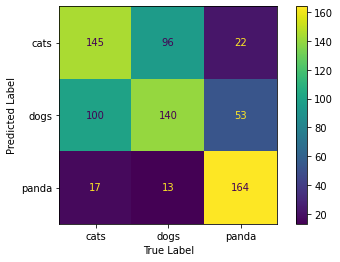

In [13]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,test_y),
                       display_labels=encoder.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [14]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

17-10-2022 00:39:53 Uploading figures


In [15]:
# create a folder named 'test'
dirname = 'test'
os.mkdir(dirname)

# re-generate test images and put all of them in test/ folder
for i in range(test_x.shape[0]):
  img = test_x[i].reshape(32,32,3)
  cv2.imwrite(os.path.join(dirname,''.join([str(i),'.jpg'])),img)

In [16]:
# sort image Paths by name
# 0.jpg, 1.jpg, 2.jpg, ....
imagePaths = list(paths.list_images("test"))
imagePaths = sorted(imagePaths, key=lambda x: int(re.search(r"(\d+)\.[a-z]+$", x).group(1)))

In [17]:
# create a table with columns we want to track/compare
preview_dt = wandb.Table(columns=["test id","image", "target","predict"])

# create a new artifact to store the EDA data
inference_result = wandb.Artifact(args["deploy"], type="INFERENCE")

In [18]:
# append all images to the artifact
for i,img in enumerate(imagePaths):
  image = cv2.imread(img)
  preview_dt.add_data(i, 
                      wandb.Image(img), 
                      encoder.inverse_transform([test_y[i]])[0], 
                      encoder.inverse_transform([predict[i]])[0])

In [19]:
# save artifact to W&B
inference_result.add(preview_dt, "Inference_Table")
run.log_artifact(inference_result)

In [20]:
run.finish()

Acc,0.59867
F1,0.60587
Precision,0.62062
Recall,0.59867
